In [ ]:
!wget -nc --no-check-certificate https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip -n inception5h.zip
!wget -nc https://sample-videos.com/video123/mp4/720/big_buck_bunny_720p_1mb.mp4
 
from io import BytesIO
from IPython.display import clear_output, Image, display
import numpy as np
import PIL.Image
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from __future__ import print_function
import cv2 , os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
model_fn = 'tensorflow_inception_graph.pb'
 
# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})
 
def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

File ‘inception5h.zip’ already there; not retrieving.

Archive:  inception5h.zip
--2021-07-23 06:04:55--  https://sample-videos.com/video123/mp4/720/big_buck_bunny_720p_1mb.mp4
Resolving sample-videos.com (sample-videos.com)... 103.145.51.95
Connecting to sample-videos.com (sample-videos.com)|103.145.51.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1055736 (1.0M) [video/mp4]
Saving to: ‘big_buck_bunny_720p_1mb.mp4’

big_buck_bunny_720p 100%[===================>]   1.01M  52.7KB/s    in 23s     

2021-07-23 06:05:25 (44.2 KB/s) - ‘big_buck_bunny_720p_1mb.mp4’ saved [1055736/1055736]



In [ ]:
video_path = "/content/big_buck_bunny_720p_1mb.mp4"
def video_to_frames(path=video_path):
    cam = cv2.VideoCapture(path)
    # frame
    currentframe = 0

    while(True):
        
    # reading from frame
        ret,frame = cam.read()

        if ret:
            # if video is still left continue creating images
            path = '/content/sample_data/frames/'
            if not os.path.exists(path):
              os.makedirs(path)
            name = path + str(currentframe) + '.jpg'
            print ('Creating...' + name)

            # writing the extracted images
            cv2.imwrite(name, frame)

            # increasing counter so that it will
            # #show how many frames are created
            currentframe += 1
        else:
            break
video_to_frames()

Creating.../content/sample_data/frames/0.jpg
Creating.../content/sample_data/frames/1.jpg
Creating.../content/sample_data/frames/2.jpg
Creating.../content/sample_data/frames/3.jpg
Creating.../content/sample_data/frames/4.jpg
Creating.../content/sample_data/frames/5.jpg
Creating.../content/sample_data/frames/6.jpg
Creating.../content/sample_data/frames/7.jpg
Creating.../content/sample_data/frames/8.jpg
Creating.../content/sample_data/frames/9.jpg
Creating.../content/sample_data/frames/10.jpg
Creating.../content/sample_data/frames/11.jpg
Creating.../content/sample_data/frames/12.jpg
Creating.../content/sample_data/frames/13.jpg
Creating.../content/sample_data/frames/14.jpg
Creating.../content/sample_data/frames/15.jpg
Creating.../content/sample_data/frames/16.jpg
Creating.../content/sample_data/frames/17.jpg
Creating.../content/sample_data/frames/18.jpg
Creating.../content/sample_data/frames/19.jpg
Creating.../content/sample_data/frames/20.jpg
Creating.../content/sample_data/frames/21.jp

In [ ]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    return Image(data=f.getvalue())

In [ ]:
# These parameters let us control the strenth of the deepdream.
octave_n = 4
octave_scale = 1.4
iter_n = 10
strength = 200

# Helper function that uses TensorFlow to resize an image
def resize(img, new_size):
    return sess.run(tf.image.resize_bilinear(img[np.newaxis,:], new_size))[0]

# Apply gradients to an image in a seires of tiles
def calc_grad_tiled(img, t_grad, tile_size=256):
    '''Random shifts are applied to the image to blur tile boundaries over
    multiple iterations.'''
    h, w = img.shape[:2]
    sx, sy = np.random.randint(tile_size, size=2)
    # We randomly roll the image in x and y to avoid seams between tiles.
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-tile_size//2, tile_size),tile_size):
        for x in range(0, max(w-tile_size//2, tile_size),tile_size):
            sub = img_shift[y:y+tile_size,x:x+tile_size]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+tile_size,x:x+tile_size] = g
    imggrad = np.roll(np.roll(grad, -sx, 1), -sy, 0)
    # Add the image gradient to the image and return the result
    return img + imggrad*(strength * 0.01 / (np.abs(imggrad).mean()+1e-7))

# Applies deepdream at multiple scales
def render_deepdream(t_obj, input_img, show_steps = True):
    # Collapse the optimization objective to a single number (the loss)
    t_score = tf.reduce_mean(t_obj)
    # We need the gradient of the image with respect to the objective
    t_grad = tf.gradients(t_score, t_input)[0]

    # split the image into a number of octaves (laplacian pyramid)
    img = input_img
    octaves = []
    for i in range(octave_n-1):
        lo = resize(img, np.int32(np.float32(img.shape[:2])/octave_scale))
        octaves.append(img-resize(lo, img.shape[:2]))
        img = lo

    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            img = calc_grad_tiled(img, t_grad)
        if show_steps:
            clear_output()
            display(showarray(img))
    return img

DEEP DREAM


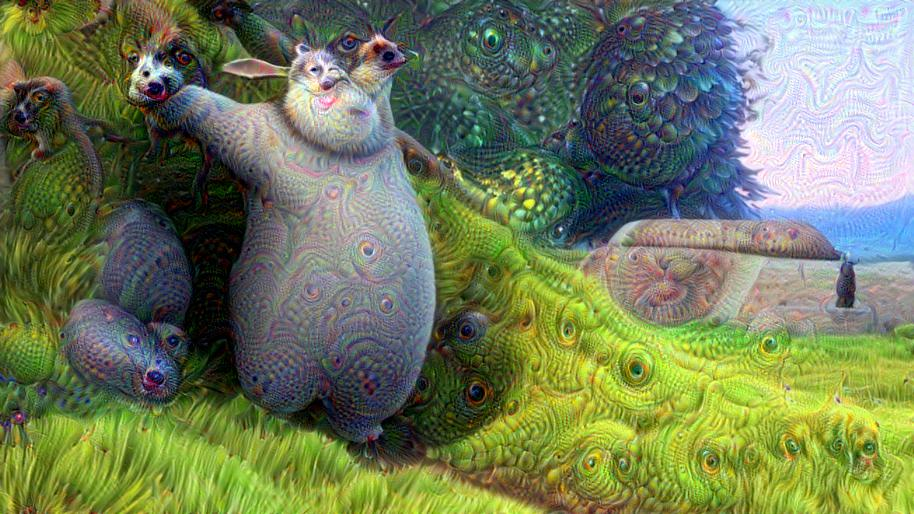

KeyboardInterrupt: ignored

In [ ]:
octave_n = 4 #@param {type:"slider", max: 10}
octave_scale = 1.4 #@param {type:"number"}
iter_n = 10 #@param {type:"slider", max: 50}
strength = 200 #@param {type:"slider", max: 1000}
layer = "mixed4c"  #@param ["mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]

def load_images_from_folder(folder="/content/sample_data/frames/"):
    images = []
    for filename in os.listdir(folder):
        path = os.path.join(folder,filename)
        contents = open(path).read() 
        img0 = sess.run(tf.image.decode_image(contents))
        tensor = render_deepdream(tf.square(T(layer)), img0)
        imng = showarray(tensor)
        display(imng)
        print(type(imng))
        path = '/content/sample_data/output/'
        if not os.path.exists(path):
          os.makedirs(path)
        _ = path +str(filename)
        open(_,'w').write(imng.data)
load_images_from_folder()